## Regression : 회귀
  - 가격이나 확률같이 연속된 출력 값을 예측

  - 평균제곱오차(MSE) : 회귀문제에서 자주 사용되는 손실함수
  - 평균절댓값오차(MAE) : 회귀문제에서 자주 사용하는 평가 지표
  - 데이터가 수치이므로 동일한 범위가 되도록 각 특성의 스케일을 조정
  - 훈련데이터가 적으면 과대적합(OverFitting)을 발생 가능
    - 은닉층의 개수가 적은 소규모 네트워크를 선택
  - Early Stopping : 과대적합을 방지하기 위한 방법

### 01. library install / import

In [1]:
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.5.0


### 02. Dataset
  - Auto MPG dataset
    - 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델
    - 자동차 정보 : 실린더 수, 배기량, 마력, 공차 중량 등 포함  
      
  - USI 머신 러닝 저장소

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                   "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'C:\\Users\\jjanh_000\\.keras\\datasets\\auto-mpg.data'

#### 02. 01. 데이터 로드
  - 판다스를 이용

In [5]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
               'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values='?', comment='\t',
                         sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 02. 02. 데이터 정제
  - 누락된 데이터
  - "Origin" : 수치형이 아닌 범주형 data
    - one-hot encoding으로 변환
    - 생산지 : 해당하는 항목에 1이 표시

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# 누락된 행 삭제
dataset = dataset.dropna()

In [8]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 02. 03. 데이터 셋 분할
  - train_dataset : 80%
  - test_dataset : 20%

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### 02. 04. 데이터 분석
  - seaborn 이용하여 산점도 분석

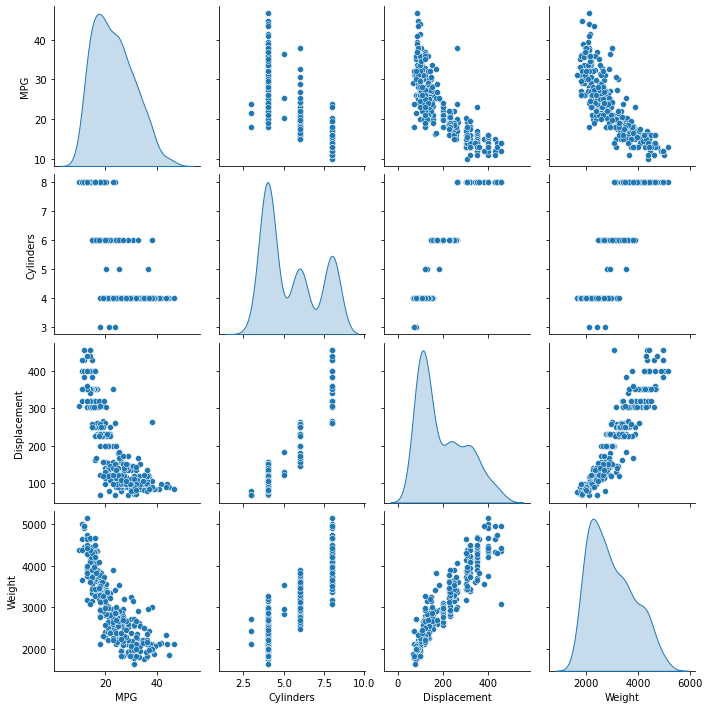

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 02. 05. 데이터 분리
  - 특성(feature)과 타깃(target 또는 레이블 label) 분리
  - 타깃(레이블)을 예측하기 위해 모델을 훈련

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 02. 06. data normalization : 정규화
  - 정규화 : 특성의 스케일과 범위가 다른 경우
  - 정규화하지 않으면 훈련이 어렵고 입력 단위에 의존적인 모델이 만들어짐
  - (x - mean) / std : 정규분포 -> 표준정규분포로 바꾸는 과정과 동일

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [15]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 03. Model Build

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [17]:
model = build_model()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 샘플로 모델을 실행해보기 : 10개
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01727405],
       [-0.06393883],
       [-0.07389501],
       [ 0.13075247],
       [ 0.6145915 ],
       [-0.08053517],
       [ 0.60943377],
       [-0.16408755],
       [-0.08883892],
       [ 0.64365196]], dtype=float32)

### 04. Model Train
  - epochs : 1000

In [23]:
class PrintDot(keras.callbacks.Callback):
    # 에포크 마다 '.' 출력하여 훈련 진행 과정 표시
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

In [24]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 05. Visualization : 시각화

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.237492,0.678099,1.237492,10.916950,2.542673,10.916950,995
996,1.193337,0.648168,1.193337,13.451137,2.817333,13.451137,996
997,1.252166,0.650864,1.252166,11.714023,2.653578,11.714023,997
998,1.231079,0.634455,1.231079,11.749521,2.670063,11.749521,998
999,0.996940,0.556938,0.996940,11.687606,2.638764,11.687606,999


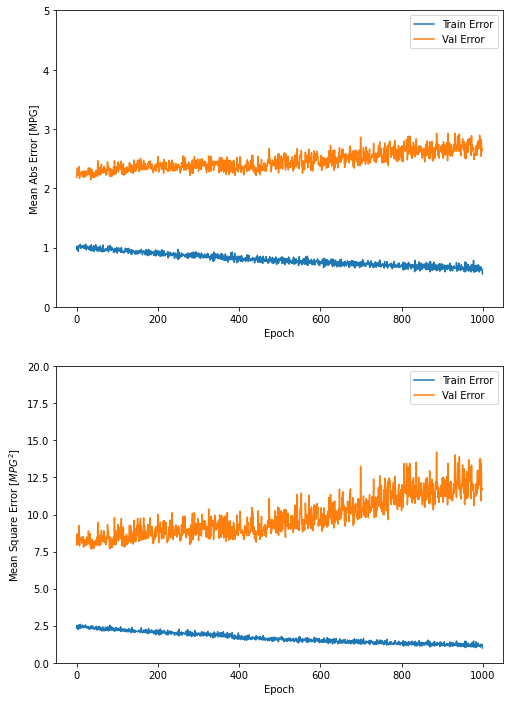

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8, 12))
    
    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()
    
plot_history(history)


....................................................................................

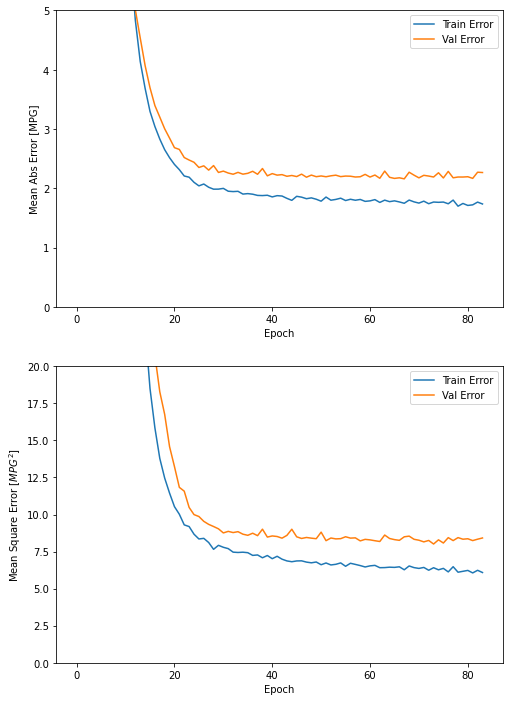

In [29]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [31]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print('테스트 세트의 평균 절대 오차: {:5.2f} MPG'.format(mae))

3/3 - 0s - loss: 5.2327 - mae: 1.7201 - mse: 5.2327
테스트 세트의 평균 절대 오차:  1.72 MPG


### 06. Prediction

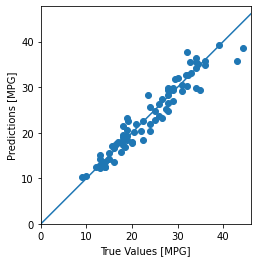

In [32]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

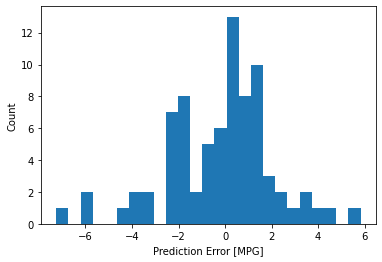

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')